In [1]:
import torch
import pandas as pd
import numpy as np
import anndata
from scipy.spatial import distance
import scanpy as sc
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import scanpy as sc
from collections import Counter
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.sparse import vstack
import time
import torch.nn as nn
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F



In [2]:
import argparse
import torch.utils.data as data
import numpy as np
import torch

def get_parser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-pretrain_batch', '--pretrain_batch',
                        type=int,
                        help='Batch size for pretraining. Default: no batch',
                        default=None)
    
    parser.add_argument('-pretrain','--pretrain',
                        type = bool,
                        default = True,
                        help='Pretrain model with autoencoder; otherwise load existing')
    
    parser.add_argument('-nepoch', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=30)

    parser.add_argument('-nepoch_pretrain', '--epochs_pretrain',
                        type=int,
                        help='number of epochs to pretrain for',
                        default=25)

    parser.add_argument('-source_file','--model_file',
                        type = str,
                        default = 'trained_models/source.pt',
                        help='location for storing source model and data')

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=20) 

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)
  
    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=3)
    
    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')
    
    return parser


'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx]
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
    
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations
    
import torch
from torch.utils.data import DataLoader ##prefetch by batch
#from model.epoch_sampler import EpochSampler


def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set.
    
    Validation_split = % keeps in training set 
    
    """
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data,
                                                  shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment 

def compute_scores(y_true, y_pred, scoring={'accuracy','precision','recall','nmi',
                                                'adj_rand','f1_score','adj_mi'}):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    scores = {}
    y_true, y_pred = hungarian_match(y_true, y_pred)
    set_scores(scores, y_true, y_pred, scoring)
        
    return scores


def set_scores(scores, y_true, y_pred, scoring):
    labels=list(set(y_true))
    
    for metric in scoring:
        if metric=='accuracy':
            scores[metric] = metrics.accuracy_score(y_true, y_pred)
        elif metric=='precision':
            scores[metric] = metrics.precision_score(y_true, y_pred, labels, average='macro')
        elif metric=='recall':
            scores[metric] = metrics.recall_score(y_true, y_pred, labels, average='macro')
        elif metric=='f1_score':
            scores[metric] = metrics.f1_score(y_true, y_pred, labels, average='macro')
        elif metric=='nmi':
            scores[metric] = metrics.normalized_mutual_info_score(y_true, y_pred)
        elif metric=='adj_mi':
            scores[metric] = metrics.adjusted_mutual_info_score(y_true, y_pred)
        elif metric=='adj_rand':
            scores[metric] = metrics.adjusted_rand_score(y_true, y_pred)
                
                
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred


def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    y = np.array(y, dtype=np.int64)
    val_set = set(y)
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y

In [3]:
def MARS_loss_tracker (training_history, save):
    
    loss = pd.DataFrame.from_dict(training_history['Loss_tracker'])
    epochs = loss.shape[0]
    
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    
    ax[0].plot(np.arange(epochs), loss['Test_anno'].values, label = "Unannotated landmark loss")
    ax[0].plot(np.arange(epochs), loss['Train_latent_loss'].values, label = "Train latent loss")
    ax[0].plot(np.arange(epochs), loss['Test_latent_loss'].values, label = "Test latent loss")
    ax[0].set_title("MARS original loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    

    ax[1].plot(np.arange(epochs), loss['Train_reconstr_loss'].values, label = "Train reconstruction loss")
    ax[1].plot(np.arange(epochs), loss['Test_reconstr_loss'].values, label = "Test reconstruction loss")
    ax[1].set_title("Reconstruction loss")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    
    
    fig.suptitle("MARS loss across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()
    
    if save == True:
        fig.savefig("MARS_loss_tracker.png")


def MARS_history(history_train, save):
    
    ###Loss function trajectory
    loss = []
    for l in history_train['Loss']:
        loss.append(l.detach().numpy())
    
    accuracy = history_train['Accuracy']
    
    ##Line plot visuzlie loss per epoch 
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    ax[0].scatter(np.arange(len(loss)),loss)
    ax[0].plot(np.arange(len(loss)),loss)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Training loss", fontsize=12)
    ax[0].set_title("Training loss", fontsize=14)
    
    ax[1].scatter(np.arange(len(accuracy)),accuracy)
    ax[1].plot(np.arange(len(accuracy)),accuracy)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Training accuracy", fontsize=12)
    ax[1].set_title("Training accuracy", fontsize=14)
    
    fig.suptitle("Visualization of MARS metrics across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    if save == True:
        fig.savefig("MARS_history.png")

    
def MARS_latent_pca(latent_tracker , epoch_num):
    ###Latent space 
    
    train_latent = latent_tracker[epoch_num]['Train_latent'][0].detach().numpy()
    train_label = latent_tracker[epoch_num]['Train_label'][0].detach().numpy()
    
    test_latent = latent_tracker[epoch_num]['Test_latent'][0].detach().numpy()
    test_label = latent_tracker[epoch_num]['Test_label'][0].detach().numpy()
    
    ###Validation PCA visualization 
    
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.columns=['PC1','PC2']
    pca_df=pca_df.copy()
    pca_df['dbscan']=train_label
    
    plt.subplots(1, figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dbscan", palette="deep")
    plt.title("Training latent space")
    plt.show()  
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(test_latent)
    pca_df=pd.DataFrame(pca.transform(test_latent))
    pca_df.columns=['PC1','PC2']
    pca_df=pca_df.copy()
    pca_df['dbscan']=test_label
    
    plt.subplots(1, figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dbscan", palette="deep")
    plt.title("Testing latent space")
    plt.show()

    
def MARS_latent_umap(adata,save, plot_gene_list = ['MARS_labels','experiment',
                                              'CST3','CCL5','FCGR3A','NKG7','MS4A1','CD79A','CD8A']  ):
    
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='MARS_embedding')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=plot_gene_list, ncols=2 )

    sub_data = adata[adata.obs['experiment']=='Unannotated',]
    if save == True:
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2, save = '.png' )
    else: 
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2 )
        
        
def cell_type_assign(adata, save):

    num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
              5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

    adata.obs['label_name']=adata.obs['truth_labels'].map(num2name)  
    untable = adata.obs.loc[adata.obs['experiment']=='Unannotated',:]
    
    groundtruth_sum = pd.crosstab(untable['truth_labels'], untable['MARS_labels']).sum(axis=1)
    plot = pd.crosstab(untable['truth_labels'], untable['MARS_labels']).div(groundtruth_sum/100, axis=0).plot.bar(figsize=(17,5), width=1)
    plot.set_xticklabels(['Malignant','Endothelial', 'T cell', 'Macrophage', 'B cell',  'CAF', 'Dendritic', 'Plasma B', 'NK' ],
                         rotation = 45)
    plot.legend(title="MARS labels")
    plot.set_xlabel("Ground truth labels", fontsize=18)
    plot.set_title("Distribution of MARS labels and Ground Truths", fontsize=24)
    plot.set_ylabel("% Truth labels in MARS labels", fontsize=18)
    plt.show()
    
    
    if save==True:
        plot.get_figure().savefig("cell_type_groundtruth.png")
    
    groundtruth_sum = pd.crosstab(untable['MARS_labels'], untable['label_name']).sum(axis=1)
    plot = pd.crosstab(untable['MARS_labels'], untable['label_name']).div(groundtruth_sum/100, axis=0).plot.bar(figsize=(17,5), width=1)
    plot.legend(title="Ground truth")
    plot.set_xlabel("MARS labels", fontsize=18)
    plot.set_ylabel("% MARS labels in Truth labels", fontsize=18)
    plt.show()
    
    if save==True:
        plot.get_figure().savefig("cell_type_MARS.png")

        
def MARS_silhouette(adata, save):
    
    
    anno_data = adata[adata.obs['experiment'] == "Annotated", :]
    unanno_data = adata[adata.obs['experiment'] == "Unannotated", :]
    
    anno_obs = anno_data.obs
    unanno_obs = unanno_data.obs
    
    ###Silhouette
    train_latent = anno_data.obsm['MARS_embedding']
    train_sil=silhouette_samples(train_latent, anno_obs['truth_labels'].values)
    
    val_latent = unanno_data.obsm['MARS_embedding']
    val_sil=silhouette_samples(val_latent, unanno_obs['truth_labels'].values)
    
    n_clusters=len(Counter(adata.obs['truth_labels'].values).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 10)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    
    
    name2num={'Malignant':1, 'Endothelial':2, 'T cell':3, 
          'Macrophage':4, 'B cell':5,'CAF':6, 
          'Dendritic':7 ,'Plasma B':8, 'NK':9}

    cluster_list = list(name2num.keys())
    
    for i in range(n_clusters):
        
        
        #cluster_label = list(Counter(adata.obs['truth_labels']).keys())[i]
        cluster_label = cluster_list[i]
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[anno_obs['label_name'] == cluster_label]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values) 
        #edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[unanno_obs['label_name'] == cluster_label]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values)
        # edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(0.8, val_y_lower + 0.5 * val_size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, anno_obs['truth_labels'].values)
    val_avg=silhouette_score(val_latent, unanno_obs['truth_labels'].values)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for MARS latent space", fontsize=14, fontweight='bold')
    plt.show()  
    
    if save ==True:
        fig.savefig("MARS_silhouette.png")
        
    return train_sil, val_sil, train_avg, val_avg

In [33]:
class VAE(nn.Module):
    '''
    '''
    def __init__(self, latent_dim , n_feature , network_architecture , 
                 lambda_reconstruct, lambda_kl ,
                 p_drop=0.2):
        
        super(VAE, self).__init__()
        
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.encoder = nn.Sequential(
            
            nn.Linear(self.n_feature, self.hidden_encode1, bias=True),
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_encode1, self.hidden_encode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_encode2, self.hidden_encode3, bias=True),
            nn.ELU(alpha=0.2)
        )
        
        self.mu = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        self.logvar = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        
        self.decoder = nn.Sequential(
            
            nn.Linear(self.latent_dim, self.hidden_decode1, bias=True),
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_decode1, self.hidden_decode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode2, self.hidden_decode3, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode3, self.n_feature, bias=True)
        )
    
    
    def encode(self, x):
        '''
        Return latent parameters
        '''
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        
        return [mu, logvar]
        
    
    def decode(self, z):
        '''
        Reconstruct
        '''
        decoded = self.decoder(z)
        return decoded
    
    
    def reparameterize(self, mu , logvar):
        ''' 
        Reparametraization sample N(mu, var) from N(0,1) noise
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) #std represents the size of the tensor
        
        return eps*std + mu                
      
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        decoded = self.decode(z)
        
        return decoded, mu, logvar
    
import torch
from torch.nn import functional as F

#from model.utils import euclidean_dist

##training set encoded distance to landmarks 
def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

##For unannotated set 
def loss_test(encoded, prototypes, tau):
    
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn


def vae_loss(model, decoded, x, mu, logvar):
    
#     loss_func = torch.nn.MSELoss()
#     loss_rcn = loss_func(decoded, x)
    #KL =  torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    loss_rcn = torch.mean(torch.sum((x - decoded).pow(2),1))
    
    KL_loss = (-0.5)*(1 + logvar - mu.pow(2) - logvar.exp())
    KL = torch.mean(torch.sum(KL_loss, axis=1))
    
    #print(model.lambda_reconstruct, model.lambda_kl)
    total_loss = model.lambda_reconstruct*loss_rcn + model.lambda_kl * KL 
    
    
    #print(f"Reconstruction Loss: {loss_rcn} KL Loss: {KL}")
    
    return total_loss 


import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans

## Training set (annotated landmarks)
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks



def init_landmarks(n_clusters, tr_load, test_load, model, device, mode='kmeans', pretrain=True):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), 
                                  model.latent_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.latent_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            #lndmk_encoded,_ = model(landmarks)
            _ , lndmk_encoded, _ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            #encoded,_ = model(X)
            decode , encoded, logvar = model(X)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded


class VAE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                 
                 latent_dim = 50, 
                 n_feature = 10, 
                 
                 network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                 
                 lambda_reconstruct = 1e-4, lambda_kl = 1e-3
                ):
        
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
        self.labeled_metadata = [data.metadata for data in labeled_data]
        self.unlabeled_metadata = unlabeled_data.metadata
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##KNN clusters
        self.n_clusters = n_clusters
        
        ##General Parameters
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
        ##VAE parameter
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
#         self.hidden_encode1=network_architecture['n_hidden_recog_1']
#         self.hidden_encode2=network_architecture['n_hidden_recog_2']
#         self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
#         self.hidden_decode1=network_architecture['n_hidden_gener_1']
#         self.hidden_decode2=network_architecture['n_hidden_gener_2']
#         self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.init_model(self.latent_dim, self.n_feature, network_architecture, 
                        self.lambda_reconstruct, self.lambda_kl, params.device)
        
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, 
                   latent_dim , 
                   n_feature, 
                   network_architecture, 
                   lambda_reconstruct, lambda_kl,
                   device
                  ):
        """
        Initialize the model.
        """
        #self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
        self.model = VAE(latent_dim = latent_dim, 
                         n_feature = n_feature, 
                         network_architecture= network_architecture,
                         lambda_reconstruct = lambda_reconstruct, 
                         lambda_kl = lambda_kl).to(device)
        
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with variational autoencoder.
        only on unannotated dataset 
        optim: optimizer
        """
        print('Pretraining..')
        
        pretrain_loss =[]
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            
            
            for _, batch in enumerate(self.pretrain_loader):
                
                x,_,_ = batch
                x = x.to(self.device)
                
                #_, decoded = self.model(x)
                decoded, mu, logvar = self.model(x)
                
                #loss = reconstruction_loss(decoded, x) 
                loss = vae_loss(self.model, decoded, x, mu, logvar)
                
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                
            pretrain_loss.append(loss) 
            
            print(f"Pretraining Epoch {e}, Loss: {loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
        return mu, pretrain_loss
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ##############################
        ####Pre train step 
        ##############################
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        
        if self.pretrain_flag:
            pretrain_latent , pretrain_loss = self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ##############################
        
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[],'Loss_tracker':[]}
        best_acc = 0
        
        for epoch in range(1, self.epochs+1):
            
            start = time.time()
            
            #########################
            #####   Model training 
            #########################
            self.model.train()
            
            ##Do_epoch train over each minibatch return
            ##training loss, accuracy, updated landmarks (annoated and unannotated)
            ##latent_history returns latents space for 1) training 2) testing 3) training landmark 4) testing landmark
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            
            ##Loss training includes 1 - VAE loss 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            print("Time: ", time.time()-start)
        
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            latent_tracker.append(latent_history)
            
            ##only print out the last epoch result indicating end of training
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            
            if self.val_loader is None:
                continue
            
            #########################
            #####   Model evaluation 
            #########################
            self.model.eval()
            
            with torch.no_grad():
                
                loss_val, acc_val = self.do_val_epoch(val_iter, landmk_tr)
                
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
           
            
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr + [torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker, pretrain_latent , pretrain_loss
        
        return adata, landmk_all, training_history, latent_tracker, pretrain_latent , pretrain_loss
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                
                task = int(task)
                x, y, cells = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                
                #encoded,_ = self.model(x)
                decoded, mu, logvar = self.model(x)
                #adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
                adata_all.append(self.pack_anndata(x, cells, mu, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
          
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        #encoded_test,_ = self.model(x_test)
        decoded, encoded_test, logvar = self.model(x_test)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    ####Originally, MARS does not care about reconstruction loss, it only minimizes embedding to landmark distances
    ####We can alter this by adding reconstruction and KL term to the total loss being regularized 
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]
                         }
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        self.set_requires_grad(False)
        
        ##Partially freeze landmark_test
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        ##Initialize gradient of landmakr_test
        optim_landmk_test.zero_grad()
        
        ##########################################################################
        ##########################################################################
        # Update centroids    
        ##########################################################################
        ##########################################################################
        
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        ###Annotated landmark (No gradient descent needed)
        for task in task_idx:
            
            ##Training set through the VAE to generate latent space
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
        
        ###Unannotated landmark (Use gradient descent to minimize)
        
        ##Unfreeze landmark_test --> autograd update centroids
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x, y_test,_ = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x)
        
        ###minimize intra cluster difference and maximize inter cluster difference 
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno']=loss
        
        ##########################################################################
        ##########################################################################
        # Update embedding
        ##########################################################################
        ##########################################################################
        
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        
        for task in task_idx:
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            
            ##Add VAE reconstruction loss to the model 
            annotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            ##Record latent space
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss']=loss
            loss_tracker['Train_reconstr_loss']=annotated_vae_loss
            
            total_loss += loss
            #total_loss += annotated_vae_loss
            
            total_accuracy += acc.item()
            
            ntasks += 1
        
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y,_ = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x)
        
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        
        ##Add VAE reconstruction loss to the model 
        unannotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss']=(loss)
        loss_tracker['Test_reconstr_loss']=(unannotated_vae_loss)
            
        total_loss += loss
        #total_loss += unannotated_vae_loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, _ = next(val_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            #encoded = self.model(x)
            decoded, encoded, logvar = self.model(x)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            val_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            #total_loss += val_vae_loss
            total_loss += loss
            total_accuracy += acc.item()
        
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        ###only get labels from labeled data
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            
            ##UMAP embedding space
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

In [6]:
scatac=sc.read_h5ad("/home/estelle860530/Getz_lab/data/scAtac_label_mit.h5ad")

sample2response={'620':'PD', 
                 '776':'PD',
                 '856_A':'PD',
                 '856_B':'PD',
                 '1224_post_Ft':'PD', 
                 '1224_post_Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227':'R',
                 '1009':'R',
                 '1130':'R'}

scatac.obs['response']=scatac.obs['orig.ident'].map(sample2response)

In [7]:
scatac.obs['dbscan']=np.zeros(scatac.X.shape[0])

for ind, name in enumerate(Counter(scatac.obs['predicted.id'])):
    if name == "malignant":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=1
    if name == "Endothelial":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=2
    if name == "T":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=3
    if name == "Macrophage":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=4
    if name == "B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=5
    if name == "CAF":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=6
    if name == "Dendritic":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=7
    if name == "Plasma B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=8
    if name == "NK":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=9

scatac.obs['dbscan'] = scatac.obs['dbscan'].astype('int32')

num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
          5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

scatac.obs['annotated_celltype']=scatac.obs['dbscan'].map(num2name)

In [9]:
multi_data = sc.read_h5ad("/home/estelle860530/Getz_lab/data/maarten.h5ad")

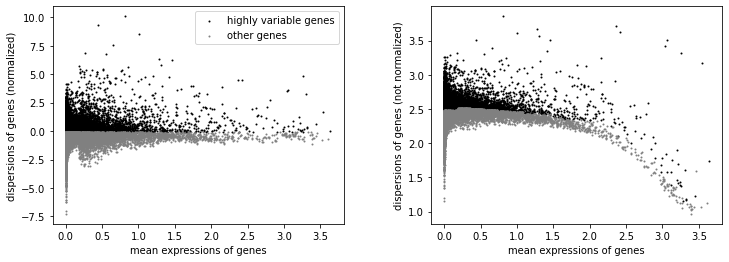

/home/estelle860530/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
sc.pp.normalize_total(multi_data, target_sum=1e4)
sc.pp.log1p(multi_data)
sc.pp.highly_variable_genes(multi_data, n_top_genes = 10000)
sc.pl.highly_variable_genes(multi_data)
multi_data.raw = multi_data  
multi_data = multi_data[:,multi_data.var.highly_variable]
sc.pp.scale(multi_data)

In [89]:
multi_numtoname = {i:name for i, name in enumerate( list(Counter(multi_data.obs['cell_type']).keys() ) ) }
multi_nametonum = {name:i for i, name in enumerate( list(Counter(multi_data.obs['cell_type']).keys() ) ) }

In [90]:
multi_data.obs['numeric_cell_type'] = multi_data.obs['cell_type'].map(multi_nametonum)

In [91]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  
                                  multi_data.var_names, 
                                  return_indices=True)

In [92]:
# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'

# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'

common_y = rna_y.append(atac_y)
common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']


In [16]:
raw_rna = multi_data.X[:,y_ind]
raw_atac = scatac.X[:,x_ind]

In [17]:
common_matrix = np.concatenate((raw_rna, raw_atac), axis=0)

raw_rna.shape, raw_atac.shape, common_matrix.shape

((65540, 488), (43956, 488), (109496, 488))

In [93]:
# Our colon data 'multi_data' and MIT data are annotated
annotated = ExperimentDataset(raw_rna, 
                              multi_data.obs.index, 
                              xy, 
                              'Annotated', 
                              rna_y['dbscan'])

# # MIT scRNA-seq data
# annotated_scrna = ExperimentDataset(raw_mit, 
#                               mit_data.obs.index, 
#                               gene_intersection, 
#                               'Annotated', mit_y['dbscan'])

# ATAC-seq data is unannotated
unannotated = ExperimentDataset(raw_atac, 
                                scatac.obs.index, 
                                xy, 
                                'Unannotated', 
                                atac_y['dbscan'])

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 30
params.pretrain_batch = 128
params.epochs = 30

== Dataset: Found 65540 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [94]:
copretrain = ExperimentDataset(common_matrix,
                               multi_data.obs.index.append(scatac.obs.index), 
                               xy,
                               'Unannotated')

In [95]:
params.epochs_pretrain = 30
params.learning_rate = 1e-3

vae_merge_mars_copre = VAE_MARS(11, params, 
                                [annotated] , 
                                unannotated, 
                                copretrain, 
                
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=1e-3,
                
                ##VAE MARS specific parameters
                latent_dim = 50 , n_feature = len(xy), 
                
                network_architecture={"n_hidden_recog_1": 250, 
                                      "n_hidden_recog_2": 100,
                                      "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                      "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                
                lambda_reconstruct = 1, lambda_kl = 1e-2)

vae_merge_adata_copre, vae_merge_landmarks_copre, vae_merge_scores_copre , vae_merge_training_history_copre, vae_merge_latent_tracker_copre, pretrainlatent, pretrainloss = vae_merge_mars_copre.train(evaluation_mode=True,
 save_all_embeddings=True)
     

Pretraining..
Pretraining Epoch 0, Loss: 422.1565856933594
Time:  7.031601190567017
Pretraining Epoch 1, Loss: 387.2268371582031
Time:  6.588847875595093
Pretraining Epoch 2, Loss: 381.29345703125
Time:  6.721914291381836
Pretraining Epoch 3, Loss: 394.45440673828125
Time:  6.621124982833862
Pretraining Epoch 4, Loss: 357.3751525878906
Time:  6.6480393409729
Pretraining Epoch 5, Loss: 279.87213134765625
Time:  6.696246862411499
Pretraining Epoch 6, Loss: 495.3358154296875
Time:  6.583438158035278
Pretraining Epoch 7, Loss: 443.8997802734375
Time:  6.578834295272827
Pretraining Epoch 8, Loss: 427.58319091796875
Time:  6.606688737869263
Pretraining Epoch 9, Loss: 470.008056640625
Time:  6.528857469558716
Pretraining Epoch 10, Loss: 466.1912841796875
Time:  6.533339738845825
Pretraining Epoch 11, Loss: 345.3431091308594
Time:  6.658252954483032
Pretraining Epoch 12, Loss: 387.2200622558594
Time:  6.55297327041626
Pretraining Epoch 13, Loss: 384.7865295410156
Time:  6.704590320587158
Pretr

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


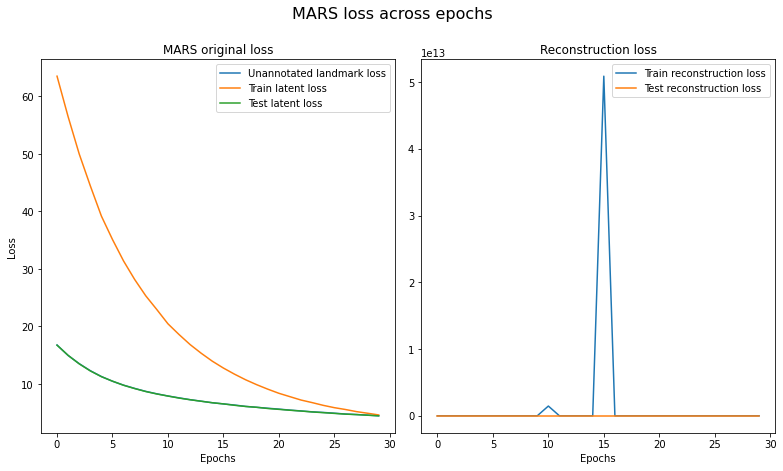

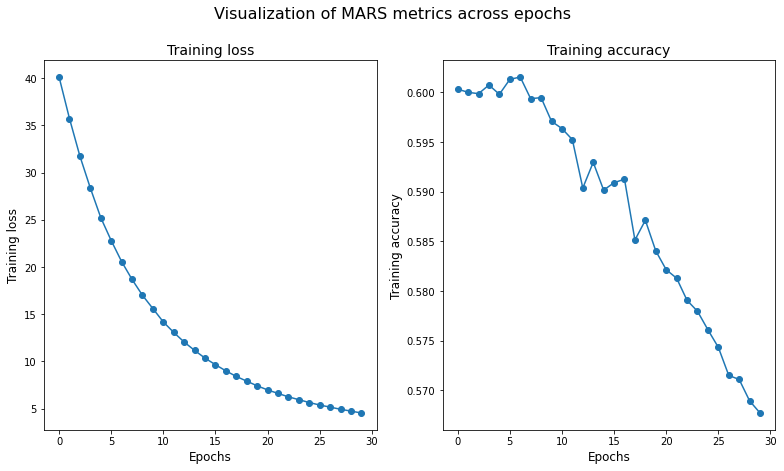

In [96]:
MARS_loss_tracker (vae_merge_training_history_copre, save = False)
MARS_history (vae_merge_training_history_copre, save = False)

... storing 'MARS_labels' as categorical


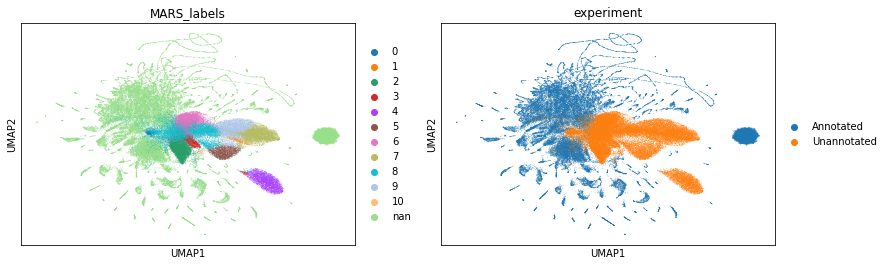

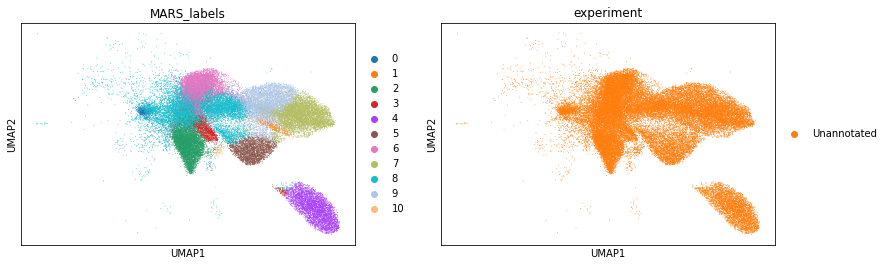

In [97]:
MARS_latent_umap(vae_merge_adata_copre, 
                 plot_gene_list = ['MARS_labels','experiment'], 
                 save = False)

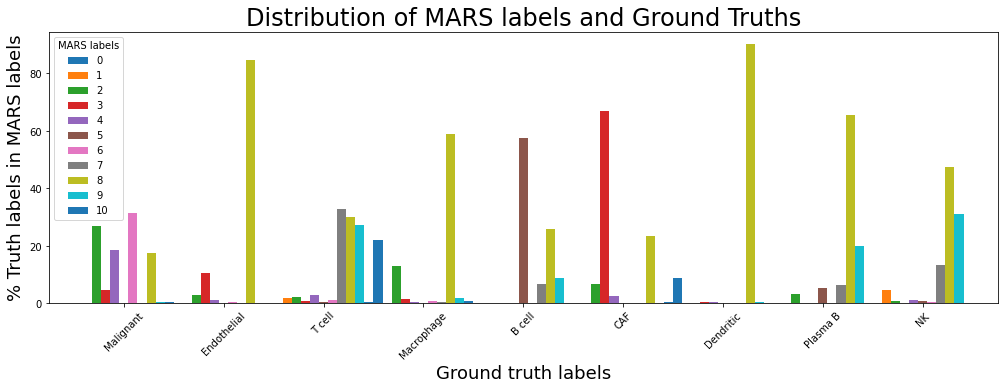

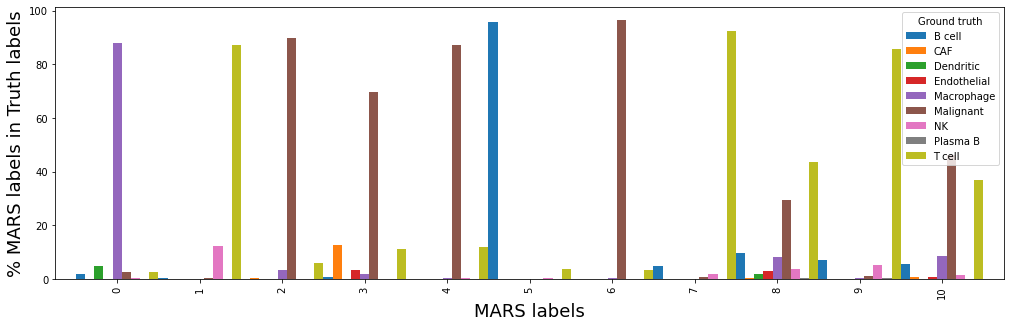

In [98]:
cell_type_assign(vae_merge_adata_copre, save = False)

In [99]:
vae_merge_scores_copre

{'accuracy': 0.35226135226135225,
 'nmi': 0.35204074758956005,
 'adj_mi': 0.351672983984811,
 'precision': 0.3509277137591231,
 'f1_score': 0.24357840804953218,
 'recall': 0.32257128896373133,
 'adj_rand': 0.18485209591830243}

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


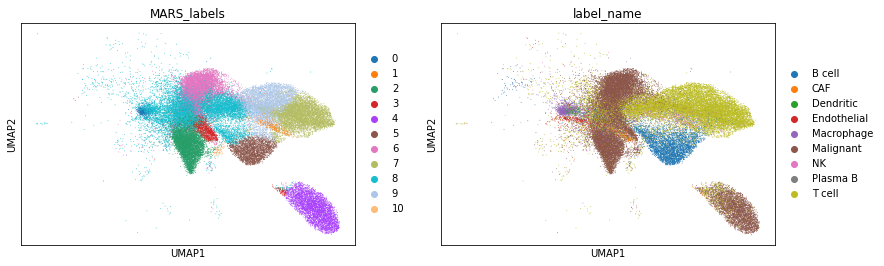

In [100]:
sc.pl.umap(vae_merge_adata_copre[vae_merge_adata_copre.obs['experiment']=="Unannotated"], 
           color=["MARS_labels",'label_name'])

... storing 'label_name' as categorical


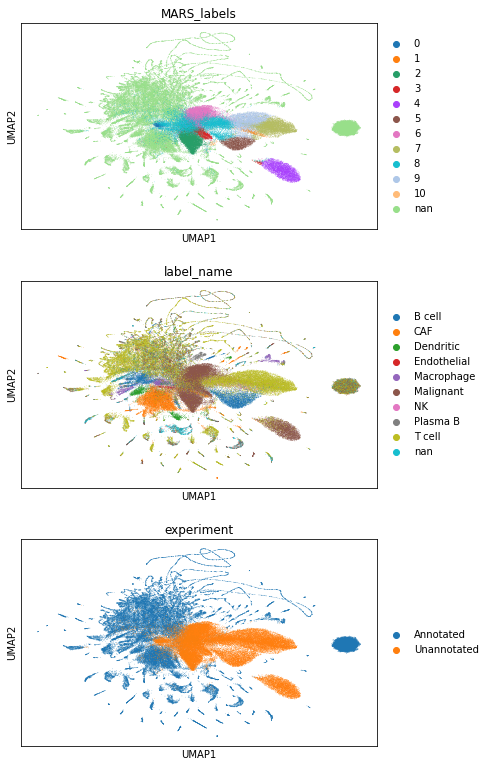

In [101]:
sc.pl.umap(vae_merge_adata_copre, 
           color=["MARS_labels",'label_name','experiment'],ncols=1)

In [45]:
len(list(multi_nametonum.keys())), len(vae_merge_landmarks_copre[0]), len(vae_merge_landmarks_copre[1])

(9, 9, 11)

In [102]:
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(vae_merge_adata_copre , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)


Cluster label: 0
5
NKs: 5.706843422036922e-17
Endothelial cells: 1.64997062503122e-14
B cell: 1.8307011291960434e-13
Fibroblasts: 3.533828026030529e-13
Monocyte: 0.9999999999994471

Cluster label: 1
5
Fibroblasts: 3.944884861818335e-11
Endothelial cells: 3.8052297161832144e-08
Mast: 8.34701850971882e-07
Monocyte: 0.0002112148476393995
NKs: 0.999787912358631

Cluster label: 10
5
Mast: 4.490986696877537e-13
Monocyte: 1.6452622986145394e-08
Glia: 0.0010508545784655079
Fibroblasts: 0.44427888988423925
Endothelial cells: 0.5546702390836634

Cluster label: 2
5
B cell: 3.7959072078921055e-11
Monocyte: 5.107194000636466e-07
Endothelial cells: 0.0010282216803030257
Glia: 0.001392877959993086
Fibroblasts: 0.9975783896004842

Cluster label: 3
5
B cell: 1.6101911929148173e-05
Monocyte: 0.0016337963516577937
Glia: 0.014535314424053846
Endothelial cells: 0.10193385348454054
Fibroblasts: 0.881867922708073

Cluster label: 4
5
Monocyte: 1.2315094329013128e-09
Mast: 1.397391081687891e-07
Endothelial ce

### CVAE

In [103]:
import argparse
import torch.utils.data as data
import numpy as np
import torch

def get_parser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-pretrain_batch', '--pretrain_batch',
                        type=int,
                        help='Batch size for pretraining. Default: no batch',
                        default=None)
    
    parser.add_argument('-pretrain','--pretrain',
                        type = bool,
                        default = True,
                        help='Pretrain model with autoencoder; otherwise load existing')
    
    parser.add_argument('-nepoch', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=30)

    parser.add_argument('-nepoch_pretrain', '--epochs_pretrain',
                        type=int,
                        help='number of epochs to pretrain for',
                        default=25)

    parser.add_argument('-source_file','--model_file',
                        type = str,
                        default = 'trained_models/source.pt',
                        help='location for storing source model and data')

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=20) 

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)
  
    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=3)
    
    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')
    
    return parser


'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx], self.metadata[idx].squeeze()
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
    
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations
    
import torch
from torch.utils.data import DataLoader ##prefetch by batch
#from model.epoch_sampler import EpochSampler


def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set.
    
    Validation_split = % keeps in training set 
    
    """
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data,
                                                  shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment 

def compute_scores(y_true, y_pred, scoring={'accuracy','precision','recall','nmi',
                                                'adj_rand','f1_score','adj_mi'}):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    scores = {}
    y_true, y_pred = hungarian_match(y_true, y_pred)
    set_scores(scores, y_true, y_pred, scoring)
        
    return scores


def set_scores(scores, y_true, y_pred, scoring):
    labels=list(set(y_true))
    
    for metric in scoring:
        if metric=='accuracy':
            scores[metric] = metrics.accuracy_score(y_true, y_pred)
        elif metric=='precision':
            scores[metric] = metrics.precision_score(y_true, y_pred, labels, average='macro')
        elif metric=='recall':
            scores[metric] = metrics.recall_score(y_true, y_pred, labels, average='macro')
        elif metric=='f1_score':
            scores[metric] = metrics.f1_score(y_true, y_pred, labels, average='macro')
        elif metric=='nmi':
            scores[metric] = metrics.normalized_mutual_info_score(y_true, y_pred)
        elif metric=='adj_mi':
            scores[metric] = metrics.adjusted_mutual_info_score(y_true, y_pred)
        elif metric=='adj_rand':
            scores[metric] = metrics.adjusted_rand_score(y_true, y_pred)
                
                
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred


def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    y = np.array(y, dtype=np.int64)
    val_set = set(y)
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y


import torch
from torch import nn
from torch.nn import functional as F

class CVAE(nn.Module):
    '''
    '''
    def __init__(self, latent_dim , n_feature , network_architecture , 
                 lambda_reconstruct, lambda_kl , batch_shape=2,
                 p_drop=0.2):
        
        super(CVAE, self).__init__()
        
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.batch_shape = batch_shape
        
        self.encoder = nn.Sequential(
            
            nn.Linear(self.n_feature + self.batch_shape , self.hidden_encode1, bias=True),
            
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_encode1, self.hidden_encode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_encode2, self.hidden_encode3, bias=True),
            nn.ELU(alpha=0.2)
        )
        
        self.mu = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        self.logvar = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        
        self.decoder = nn.Sequential(
            
            nn.Linear(self.latent_dim + self.batch_shape, self.hidden_decode1, bias=True),
            
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_decode1, self.hidden_decode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode2, self.hidden_decode3, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode3, self.n_feature, bias=True)
        )
    
    
    def encode(self, x):
        '''
        Return latent parameters
        '''
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        
        return [mu, logvar]
        
    
    def decode(self, z):
        '''
        Reconstruct
        '''
        decoded = self.decoder(z)
        return decoded
    
    
    def reparameterize(self, mu , logvar):
        ''' 
        Reparametraization sample N(mu, var) from N(0,1) noise
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) #std represents the size of the tensor
        
        return eps*std + mu                
      
    def forward(self, x, batch_label):
        
        x = torch.cat((x, batch_label), dim=1)
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        z = torch.cat((z, batch_label), dim=1)
        
        decoded = self.decode(z)
        
        return decoded, mu, logvar
    
def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

##For unannotated set 
def loss_test(encoded, prototypes, tau):
    
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn


def vae_loss(model, decoded, x, mu, logvar):
    
#     loss_func = torch.nn.MSELoss()
#     loss_rcn = loss_func(decoded, x)
    #KL =  torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    loss_rcn = torch.mean(torch.sum((x - decoded).pow(2),1))
    
    KL_loss = (-0.5)*(1 + logvar - mu.pow(2) - logvar.exp())
    KL = torch.mean(torch.sum(KL_loss, axis=1))
    
    #print(model.lambda_reconstruct, model.lambda_kl)
    total_loss = model.lambda_reconstruct*loss_rcn + model.lambda_kl * KL 
    
    
    #print(f"Reconstruction Loss: {loss_rcn} KL Loss: {KL}")
    
    return total_loss 

import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans

## Training set (annotated landmarks)
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks

def init_landmarks(n_clusters, tr_load, test_load,
                   model, device, mode='kmeans', pretrain=True
                   ):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), 
                                  model.latent_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.latent_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    batch_label = torch.stack([dataset.metadata[i] for i in range(nexamples)])
    
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            #lndmk_encoded,_ = model(landmarks)
            _ , lndmk_encoded, _ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            #encoded,_ = model(X)
            decode , encoded, logvar = model(X, batch_label)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded

class CVAE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                 
                 latent_dim = 50, 
                 n_feature = 10, 
                 
                 network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                 
                 lambda_reconstruct = 1e-4, lambda_kl = 1e-3, batch_shape = 2
                ):
        
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
#         self.labeled_metadata = [data.metadata for data in labeled_data]
#         self.unlabeled_metadata = unlabeled_data.metadata
        
        self.labeled_metadata = ["Annotated"]
        self.unlabeled_metadata = "Unannotated"
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##KNN clusters
        self.n_clusters = n_clusters
        
        ##General Parameters
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
        ##VAE parameter
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
#         self.hidden_encode1=network_architecture['n_hidden_recog_1']
#         self.hidden_encode2=network_architecture['n_hidden_recog_2']
#         self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
#         self.hidden_decode1=network_architecture['n_hidden_gener_1']
#         self.hidden_decode2=network_architecture['n_hidden_gener_2']
#         self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.batch_shape = batch_shape
        
        self.init_model(self.latent_dim, self.n_feature, network_architecture, 
                        self.lambda_reconstruct, self.lambda_kl, params.device, self.batch_shape)
        
        #print(self.lambda_reconstruct)
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, 
                   latent_dim , 
                   n_feature, 
                   network_architecture, 
                   lambda_reconstruct, lambda_kl,
                   device, batch_shape
                  ):
        """
        Initialize the model.
        """
        #self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
        self.model = CVAE(latent_dim = latent_dim, 
                         n_feature = n_feature, 
                         network_architecture= network_architecture,
                         lambda_reconstruct = lambda_reconstruct, 
                         lambda_kl = lambda_kl,
                         batch_shape = batch_shape
                        ).to(device)
        
        
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with variational autoencoder.
        only on unannotated dataset 
        optim: optimizer
        """
        print('Pretraining..')
        
        pretrain_loss =[]
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            
            
            for _, batch in enumerate(self.pretrain_loader):
                
                x, y, cell_name, batch_label = batch
                
                x = x.to(self.device)
                batch_label = batch_label.to(self.device)
                
#                 print(batch_label.shape)
#                 print(x.shape)
                
                #_, decoded = self.model(x)
                decoded, mu, logvar = self.model(x , batch_label )
                
                #loss = reconstruction_loss(decoded, x) 
                loss = vae_loss(self.model, decoded, x, mu, logvar)
                
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                
            pretrain_loss.append(loss) 
            
            print(f"Pretraining Epoch {e}, Loss: {loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
        return mu, pretrain_loss
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ##############################
        ####Pre train step 
        ##############################
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        
        if self.pretrain_flag:
            pretrain_latent , pretrain_loss = self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ##############################
        
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[],'Loss_tracker':[]}
        best_acc = 0
        
        for epoch in range(1, self.epochs+1):
            
            start = time.time()
            
            #########################
            #####   Model training 
            #########################
            self.model.train()
            
            ##Do_epoch train over each minibatch return
            ##training loss, accuracy, updated landmarks (annoated and unannotated)
            ##latent_history returns latents space for 1) training 2) testing 3) training landmark 4) testing landmark
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            
            ##Loss training includes 1 - VAE loss 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            print("Time: ", time.time()-start)
        
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            latent_tracker.append(latent_history)
            
            ##only print out the last epoch result indicating end of training
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            
            if self.val_loader is None:
                continue
            
            #########################
            #####   Model evaluation 
            #########################
            self.model.eval()
            
            with torch.no_grad():
                
                loss_val, acc_val = self.do_val_epoch(val_iter, landmk_tr)
                
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
           
            
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr + [torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker, pretrain_latent , pretrain_loss
        
        return adata, landmk_all, training_history, latent_tracker, pretrain_latent , pretrain_loss
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                
                task = int(task)
                
                x, y, cells, batch_label = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                
                #encoded,_ = self.model(x)
                decoded, mu, logvar = self.model(x , batch_label)
                #adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
                adata_all.append(self.pack_anndata(x, cells, mu, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
          
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells, batch_label = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        #encoded_test,_ = self.model(x_test)
        decoded, encoded_test, logvar = self.model(x_test, batch_label)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    ####Originally, MARS does not care about reconstruction loss, it only minimizes embedding to landmark distances
    ####We can alter this by adding reconstruction and KL term to the total loss being regularized 
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]
                         }
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        self.set_requires_grad(False)
        
        ##Partially freeze landmark_test
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        ##Initialize gradient of landmakr_test
        optim_landmk_test.zero_grad()
        
        ##########################################################################
        ##########################################################################
        # Update centroids    
        ##########################################################################
        ##########################################################################
        
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        ###Annotated landmark (No gradient descent needed)
        for task in task_idx:
            
            ##Training set through the VAE to generate latent space
            task = int(task)
            x, y, cell, batch_label = next(tr_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
        
        ###Unannotated landmark (Use gradient descent to minimize)
        
        ##Unfreeze landmark_test --> autograd update centroids
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x, y_test, cell , batch_label = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x, batch_label)
        
        ###minimize intra cluster difference and maximize inter cluster difference 
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno']=loss
        
        ##########################################################################
        ##########################################################################
        # Update embedding
        ##########################################################################
        ##########################################################################
        
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        
        for task in task_idx:
            task = int(task)
            x, y, cell, batch_label = next(tr_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            
            ##Add VAE reconstruction loss to the model 
            annotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            ##Record latent space
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss']=loss
            loss_tracker['Train_reconstr_loss']=annotated_vae_loss
            
            total_loss += loss
            #total_loss += annotated_vae_loss
            
            total_accuracy += acc.item()
            
            ntasks += 1
        
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y, cell, batch_label = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x, batch_label)
        
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        
        ##Add VAE reconstruction loss to the model 
        unannotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss']=(loss)
        loss_tracker['Test_reconstr_loss']=(unannotated_vae_loss)
            
        total_loss += loss
        #total_loss += unannotated_vae_loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, cell, batch_label = next(val_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            val_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            #total_loss += val_vae_loss
            total_loss += loss
            total_accuracy += acc.item()
        
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        ###only get labels from labeled data
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            
            ##UMAP embedding space
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

In [104]:
import torch.nn.functional as F

label = torch.as_tensor (np.concatenate( (np.zeros(raw_rna.shape[0]),np.ones(raw_atac.shape[0]) ), axis=0))
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 2)

cvae_annotated = ExperimentDataset(raw_rna, 
                                   multi_data.obs.index, 
                                   xy, 
                                   one_hot_label[:raw_rna.shape[0]], rna_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     xy, 
                                     one_hot_label[raw_rna.shape[0]:], atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(common_matrix,
                               multi_data.obs.index.append(scatac.obs.index), 
                               xy,
                               one_hot_label)

# cvae_pretrain = ExperimentDataset(raw_atac, 
#                              scatac.obs.index, 
#                              xy,
#                              one_hot_label[raw_rna.shape[0]:])

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 30
params.pretrain_batch = 128
params.epochs = 30

== Dataset: Found 65540 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [107]:
cvae_mars = CVAE_MARS(n_clusters, 
                      params, 
                      [cvae_annotated], cvae_unannotated, cvae_pretrain, 
                      
                      val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                      latent_dim = 50, n_feature = xy.shape[0], 
                      network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                      lambda_reconstruct = 1, lambda_kl = 1e-2, batch_shape = 2)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata, cvae_landmarks, cvae_scores, cvae_training_history, cvae_latent_tracker, cvae_pretrain_latent , cave_pretrain_loss = cvae_mars.train(evaluation_mode=True,
                                                                                                                                                 save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 571.86572265625
Time:  7.3981451988220215
Pretraining Epoch 1, Loss: 428.9613037109375
Time:  7.144448757171631
Pretraining Epoch 2, Loss: 267.7547912597656
Time:  7.3792126178741455
Pretraining Epoch 3, Loss: 399.5028076171875
Time:  7.21820068359375
Pretraining Epoch 4, Loss: 406.050537109375
Time:  7.300742149353027
Pretraining Epoch 5, Loss: 344.51885986328125
Time:  7.239115476608276
Pretraining Epoch 6, Loss: 433.6664123535156
Time:  7.253005504608154
Pretraining Epoch 7, Loss: 371.1030578613281
Time:  7.397320747375488
Pretraining Epoch 8, Loss: 344.292236328125
Time:  7.39443826675415
Pretraining Epoch 9, Loss: 312.8236389160156
Time:  7.298997402191162
Pretraining Epoch 10, Loss: 332.7901611328125
Time:  7.245916366577148
Pretraining Epoch 11, Loss: 357.6019592285156
Time:  7.280334234237671
Pretraining Epoch 12, Loss: 322.4075622558594
Time:  7.386687994003296
Pretraining Epoch 13, Loss: 425.51409912109375
Time:  7.349891424179077
Pret

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


... storing 'MARS_labels' as categorical


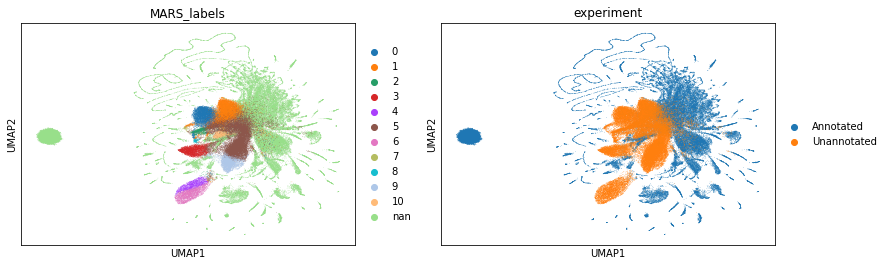

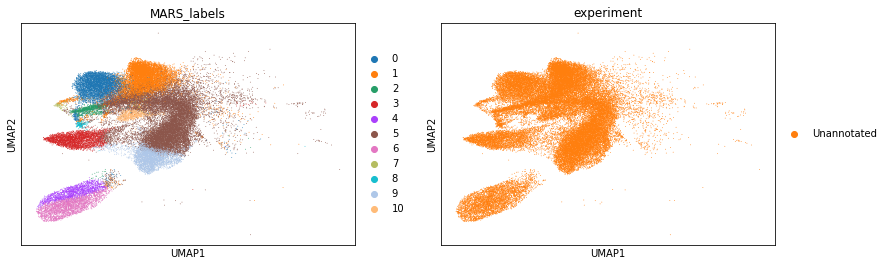

In [108]:
MARS_latent_umap(cvae_adata, plot_gene_list = ['MARS_labels','experiment'], save=".png")

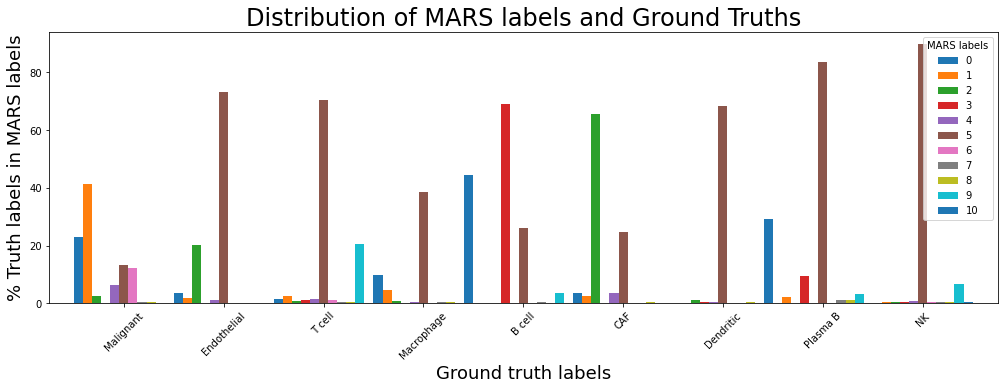

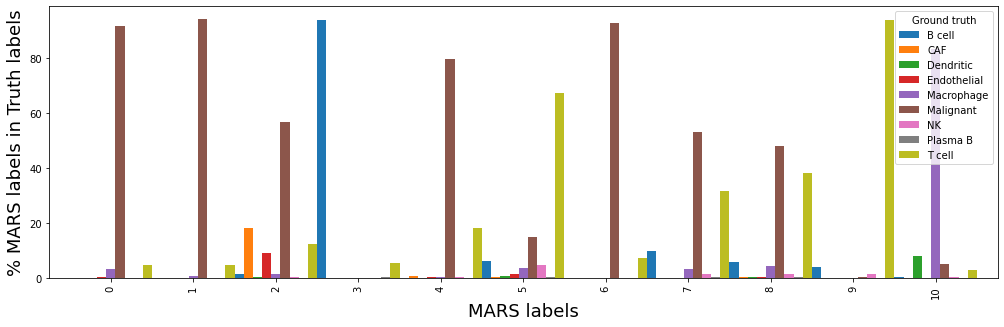

In [109]:
cell_type_assign(cvae_adata, save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


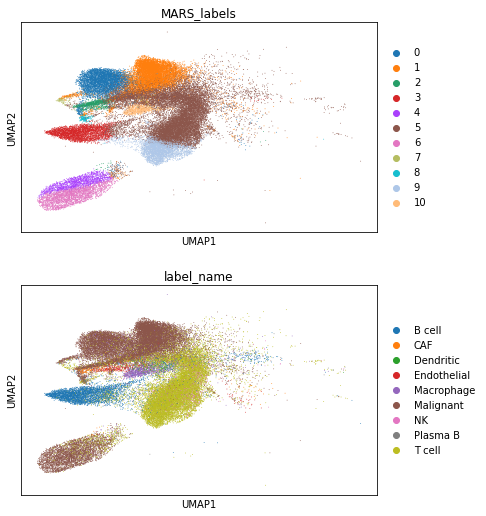

In [110]:
sc.pl.umap(cvae_adata[cvae_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=1)

In [111]:
cvae_scores

{'accuracy': 0.5383337883337883,
 'nmi': 0.3854751523489856,
 'adj_mi': 0.3851023740174725,
 'precision': 0.3999716496843959,
 'f1_score': 0.329292345485526,
 'recall': 0.33522872213374055,
 'adj_rand': 0.2640205986153234}

In [ ]:
mars_cvae_celltype= cvae_mars.name_cell_types(cvae_adata , cvae_landmarks, list(multi_nametonum.keys()))


Cluster label: 0
CD8+ T cell: 1.9407051093895094e-07
Endothelial cells: 0.004661846970740296
Mast: 0.3154940980178549
Fibroblasts: 0.3298642142121196
Monocyte: 0.3499795705098212

Cluster label: 1
NKs: 0.00012984586733764904
CD8+ T cell: 0.0006259038064311244
Fibroblasts: 0.10312187431943408
Mast: 0.3711395800647953
Monocyte: 0.5249490525392378

Cluster label: 10
NKs: 1.3752650654068954e-13
CD8+ T cell: 4.932074442432348e-13
Mast: 3.868744308179242e-12
Fibroblasts: 1.7871970165893003e-11
Monocyte: 0.9999999999776237

Cluster label: 2
Mast: 7.113810671921613e-16
Glia: 7.380015344778965e-16
Monocyte: 1.7239581013868584e-10
Endothelial cells: 0.0022537227403911344
Fibroblasts: 0.9977462770872116

Cluster label: 3
Fibroblasts: 6.500173822754829e-19
Monocyte: 0.0010788467027989619
NKs: 0.012152921795180254
CD8+ T cell: 0.100258578931904
B cell: 0.8865096525701168

Cluster label: 4
NKs: 3.691127072053863e-11
Monocyte: 5.767302302267576e-09
Glia: 5.413173113341962e-07
Endothelial cells: 1.24

In [115]:
### AE MARS

import torch.nn as nn
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F

#from model.utils import euclidean_dist

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations
    
'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx]
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]
    
    

def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set."""
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data, shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

def loss_test(encoded, prototypes, tau):
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn

#############################################
#############################################
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks

#############################################
#############################################


def init_landmarks(n_clusters, tr_load, test_load, model, device, mode='kmeans', pretrain=True):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), model.z_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.z_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            lndmk_encoded,_ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            encoded,_ = model(X)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded


def full_block(in_features, out_features, p_drop):
        return nn.Sequential(
            nn.Linear(in_features, out_features, bias=True),
            nn.LayerNorm(out_features),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        )

class FullNet(nn.Module):
    '''
    '''
    def __init__(self, x_dim, hid_dim=64, z_dim=64, p_drop=0.2):
        super(FullNet, self).__init__()
        
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )
        
        self.decoder = nn.Sequential(
            full_block(z_dim, hid_dim, p_drop),
            full_block(hid_dim, x_dim, p_drop),
        )
      
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded


class AE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2):
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
        self.labeled_metadata = [data.metadata for data in labeled_data]
        self.unlabeled_metadata = unlabeled_data.metadata
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##Feed forward neural net
        self.init_model(x_dim, hid_dim_1, hid_dim_2, p_drop, params.device)
        
        self.n_clusters = n_clusters
        
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, x_dim, hid_dim, z_dim, p_drop, device):
        """
        Initialize the model.
        """
        self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
    
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########Will need to alter this part for VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with autoencoder.
        optim: optimizer
        """
        print('Pretraining..')
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            epoch_loss = 0
            for _, batch in enumerate(self.pretrain_loader):
                x,_,_ = batch
                x = x.to(self.device)
                _, decoded = self.model(x)
                loss = reconstruction_loss(decoded, x) 
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                epoch_loss += loss 
                
            print(f"Pretraining Epoch {e}, Loss: {epoch_loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
            
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ####Pre train step 
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        if self.pretrain_flag:
            self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ####
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[], 'Loss_tracker':[]}
        
        best_acc = 0
        for epoch in range(1, self.epochs+1):
            
            ##Set model for training
            self.model.train()
            start = time.time()
            ##This is equivalent to train step 
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, 
                                                                                    test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            ##Loss training includes 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            
            latent_tracker.append(latent_history)
            
            print('Time: ', time.time()-start)
            
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            if self.val_loader is None:
                continue
            self.model.eval()
            ##Stop training 
            
            with torch.no_grad():
                loss_val,acc_val = self.do_val_epoch(val_iter, landmk_tr)
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr+[torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker
        
        return adata, landmk_all, training_history, latent_tracker
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                task = int(task)
                x, y, cells = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                encoded,_ = self.model(x)
                adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

            
        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
        #test_iter = iter(self.test_loader)
            
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        encoded_test,_ = self.model(x_test)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]}
        
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        
        self.set_requires_grad(False)
        
        for landmk in landmk_test:
            landmk.requires_grad=False
        
        optim_landmk_test.zero_grad()
        
        # update centroids    
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        
        ###Annotated landmark 
        for task in task_idx:
            
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded,_ = self.model(x)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
            
        ###Unannotated landmark
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x,y_test,_ = next(test_iter)
        x = x.to(self.device)
        encoded,_ = self.model(x)
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno'] = loss
        
        # update embedding
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        for task in task_idx:
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded, decoded = self.model(x)
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            total_loss += loss
            total_accuracy += acc.item()
            ntasks += 1
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss'] = loss
            loss_tracker['Train_reconstr_loss'] = reconstruction_loss(decoded, x)
            
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y,_ = next(test_iter)
        x = x.to(self.device)
        encoded, decoded = self.model(x)
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss'] = loss
        loss_tracker['Test_reconstr_loss'] = reconstruction_loss(decoded, x)
        
        total_loss += loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, _ = next(val_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded = self.model(x)
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            total_loss += loss
            total_accuracy += acc.item()
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

In [116]:
# Our colon data 'multi_data' and MIT data are annotated
annotated = ExperimentDataset(raw_rna, 
                              multi_data.obs.index, 
                              xy, 
                              'Annotated', 
                              rna_y['dbscan'])

unannotated = ExperimentDataset(raw_atac, 
                                scatac.obs.index, 
                                xy, 
                                'Unannotated', 
                                atac_y['dbscan'])

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 30
params.pretrain_batch = 128
params.epochs = 30

copretrain = ExperimentDataset(common_matrix,
                               multi_data.obs.index.append(scatac.obs.index), 
                               xy,
                               'Unannotated')

== Dataset: Found 65540 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [117]:
ae_merge_mars = AE_MARS(n_clusters, params, [annotated] , unannotated, copretrain, 
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2)

ae_merge_adata, ae_merge_landmarks, ae_merge_scores , ae_merge_training_history, ae_merge_latent_tracker = ae_merge_mars.train(evaluation_mode=True,
                                                                                                                               save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 611.2935180664062
Time:  8.936331272125244
Pretraining Epoch 1, Loss: 470.8254089355469
Time:  9.209237575531006
Pretraining Epoch 2, Loss: 405.8499450683594
Time:  9.2062246799469
Pretraining Epoch 3, Loss: 370.5969543457031
Time:  9.06478762626648
Pretraining Epoch 4, Loss: 346.4255065917969
Time:  9.204865217208862
Pretraining Epoch 5, Loss: 327.3919677734375
Time:  9.20160436630249
Pretraining Epoch 6, Loss: 312.0980224609375
Time:  9.561384201049805
Pretraining Epoch 7, Loss: 299.13720703125
Time:  9.316805601119995
Pretraining Epoch 8, Loss: 287.66510009765625
Time:  9.185397624969482
Pretraining Epoch 9, Loss: 277.86871337890625
Time:  9.203622102737427
Pretraining Epoch 10, Loss: 269.7396240234375
Time:  9.033237218856812
Pretraining Epoch 11, Loss: 262.68890380859375
Time:  9.15952467918396
Pretraining Epoch 12, Loss: 256.3426208496094
Time:  9.258864402770996
Pretraining Epoch 13, Loss: 250.7527313232422
Time:  9.109505891799927
Pretra

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [118]:
ae_merge_scores

{'accuracy': 0.37664937664937664,
 'nmi': 0.4016396612393524,
 'adj_mi': 0.40132887822434954,
 'precision': 0.3829455344748707,
 'f1_score': 0.2861405728085573,
 'recall': 0.3769421738153409,
 'adj_rand': 0.23437330153070454}

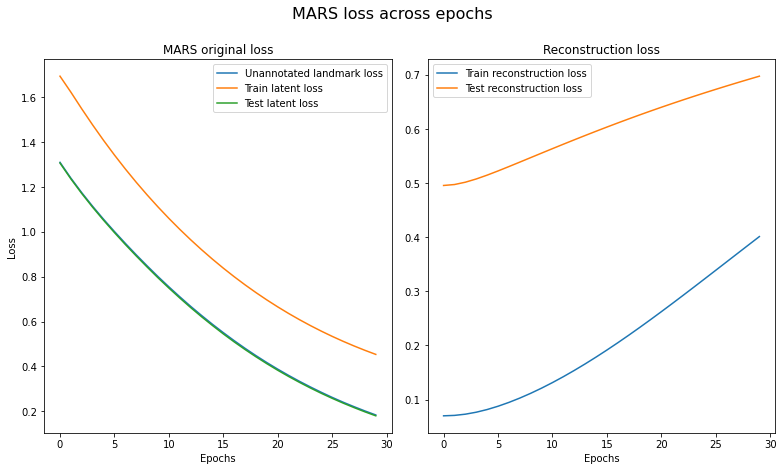

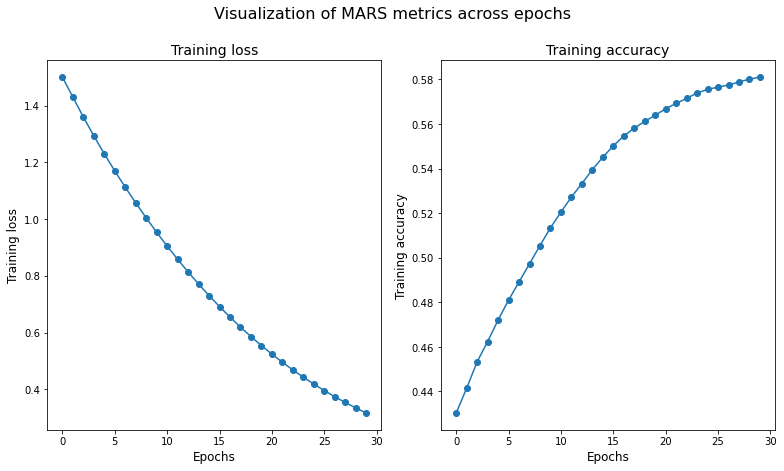

In [119]:
MARS_loss_tracker (ae_merge_training_history, save = False)
MARS_history (ae_merge_training_history, save = False)

... storing 'MARS_labels' as categorical


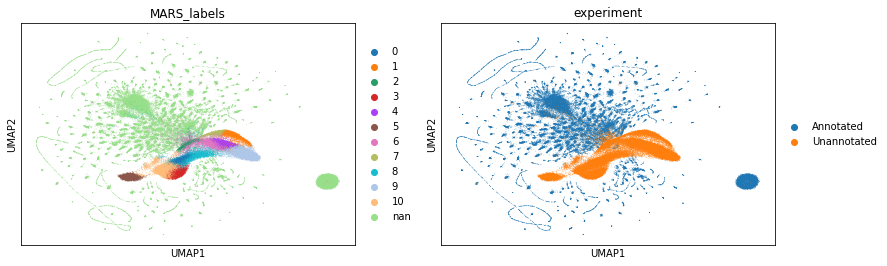

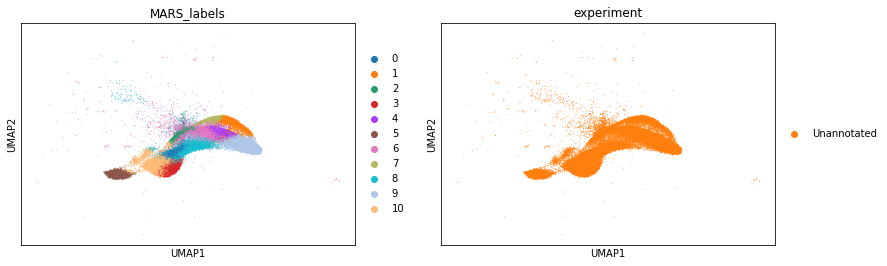

In [120]:
MARS_latent_umap(ae_merge_adata, plot_gene_list = ['MARS_labels','experiment'], save=False)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


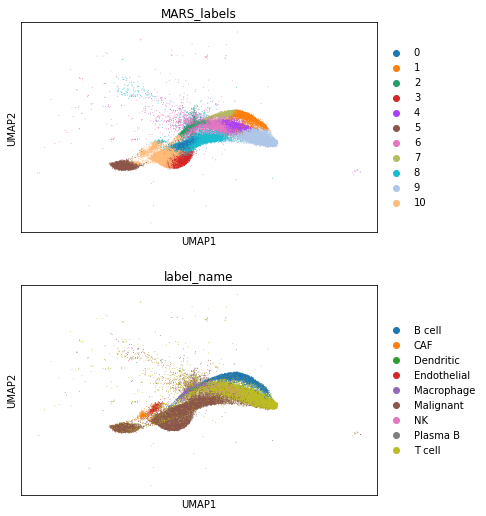

In [125]:
sc.pl.umap(ae_merge_adata[ae_merge_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels','label_name'], ncols=1)

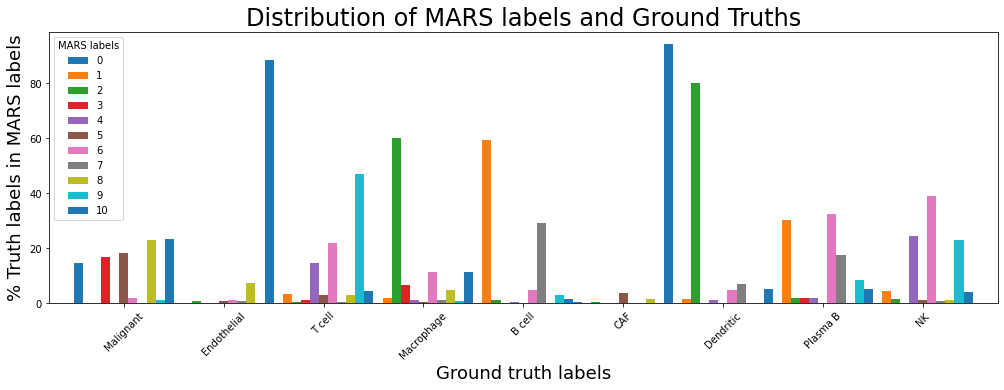

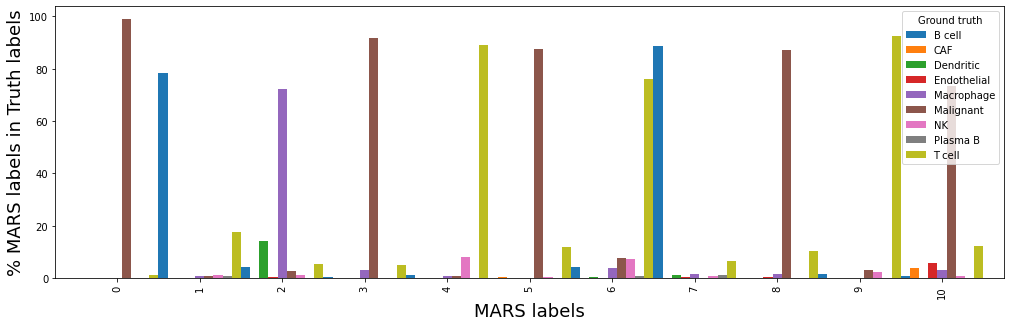

In [122]:
cell_type_assign(ae_merge_adata, save=True)

In [ ]:
mars_ae_celltype = ae_merge_mars.name_cell_types(ae_merge_adata , 
                                                 ae_merge_landmarks, 
                                                 list(multi_nametonum.keys()))